## Arctic Chlor Data Review

- mooring data pulled from ERDDAP (preliminary and/or final)   
- currently on downdraft
- chlor data from 2016/2017
- par data from 2016/2017

In [1]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter

import cmocean

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [3]:
server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

**Lets find all erddap datasets that would be associated with Arctic:**  
+ 16ck, 17ck

In [150]:
e = ERDDAP(server=server_url)
df_1 = pd.read_csv(e.get_search_url(response='csv', search_for='17ck'))
e = ERDDAP(server=server_url)
df_2 = pd.read_csv(e.get_search_url(response='csv', search_for='16ck'))

df = pd.concat([df_1,df_2])
print(df['Dataset ID'].values)

['datasets_Mooring_17ckp10a_final' 'datasets_Mooring_17ckp10a_preliminary'
 'datasets_Mooring_17ckp11a_final' 'datasets_Mooring_17ckp11a_preliminary'
 'datasets_Mooring_17ckp12a_final' 'datasets_Mooring_17ckp12a_preliminary'
 'datasets_Mooring_17ckp1a_final' 'datasets_Mooring_17ckp1a_preliminary'
 'datasets_Mooring_17ckp2a_final' 'datasets_Mooring_17ckp2a_preliminary'
 'datasets_Mooring_17ckp3a_final' 'datasets_Mooring_17ckp3a_preliminary'
 'datasets_Mooring_17ckp4a_final' 'datasets_Mooring_17ckp4a_preliminary'
 'datasets_Mooring_17ckp5a_final' 'datasets_Mooring_17ckp5a_preliminary'
 'erddap_17ckitaem2a_prawler' 'erddap_17ckitaem2a_met'
 'datasets_Mooring_16ckip1a_preliminary' 'datasets_Mooring_16ckip2a_final'
 'datasets_Mooring_16ckip2a_preliminary'
 'datasets_Mooring_16ckip3a_preliminary' 'datasets_Mooring_16ckp10a_final'
 'datasets_Mooring_16ckp10a_preliminary' 'datasets_Mooring_16ckp11a_final'
 'datasets_Mooring_16ckp11a_preliminary' 'datasets_Mooring_16ckp12a_final'
 'datasets_Moo

In [151]:
variables = [e.get_var_by_attr(dataset_id=dataset, standard_name=lambda v: v is not None) for dataset in df['Dataset ID'].values]
flatten = lambda l: [item for sublist in l for item in sublist]
flat = flatten(variables)
print(set(flat))

{'latitude', 'salinity', 'Oxy_Temperature', 'Salinity', 'northward_wind', 'Chlorophyll_Fluorescence', 'time', 'longitude', 'wind_from_direction', 'temperature', 'Turbidity', 'SigmaT', 'Chlorophyll', 'Oxygen_Saturation', 'Temperature', 'wind_speed', 'air_pressure', 'air_temperature', 'eastward_wind', 'Oxy_Sat', 'Oxygen_Concentration', 'Oxy_Conc', 'depth', 'relative_humidity'}


In [152]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in df['Dataset ID'].values:
    print(dataset_id)
    if 'prawler' in dataset_id:
        continue
    """    
    if 'preliminary' in dataset_id:
        continue
    """
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id

        d.variables = ['time','depth','Chlorophyll_Fluorescence','PAR']
        
        print(d.get_download_url())
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        #df_m.dropna(inplace=True) #placing it here drops na values prior to qc of relevant datastreams

        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['PAR'][df_m['PAR'] > 1e34] = np.nan # only in primary param fields 
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        df_m['Chlorophyll_Fluorescence'][(df_m.depth == -9999)] = np.nan # only in pressure field
        df_m['Chlorophyll_Fluorescence'][df_m['Chlorophyll_Fluorescence'] > 1e34] = np.nan # only in primary param fields 

        dfs.update({dataset_id:df_m})
    except:
        pass



datasets_Mooring_17ckp10a_final
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp10a_final.csv?time,depth,Chlorophyll_Fluorescence,PAR
datasets_Mooring_17ckp10a_preliminary
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp10a_preliminary.csv?time,depth,Chlorophyll_Fluorescence,PAR
datasets_Mooring_17ckp11a_final
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp11a_final.csv?time,depth,Chlorophyll_Fluorescence,PAR
datasets_Mooring_17ckp11a_preliminary
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp11a_preliminary.csv?time,depth,Chlorophyll_Fluorescence,PAR
datasets_Mooring_17ckp12a_final
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp12a_final.csv?time,depth,Chlorophyll_Fluorescence,PAR
datasets_Mooring_17ckp12a_preliminary
http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17ckp12a_preliminary.csv?time,depth,Chlorophyll_Fluorescence,PAR
data

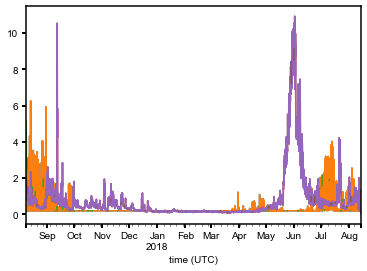

In [153]:
# when only one variable is retrieve, seeking and dropping missing rows is fine, but if two vars are... you have to be more creative and
#  either drop just the missing data for the variable in hand or...
#  resample data to a good time base (which ignores NAN's)

dfs['datasets_Mooring_17ckp2a_final'].resample('1H').mean()['PAR'].plot()
dfs['datasets_Mooring_17ckp2a_final']['PAR'].dropna().plot()
dfs['datasets_Mooring_17ckp2a_final']['PAR'].plot()

dfs['datasets_Mooring_17ckp2a_final'].resample('1H').mean()['Chlorophyll_Fluorescence'].plot()
dfs['datasets_Mooring_17ckp2a_final']['Chlorophyll_Fluorescence'].dropna().plot()
dfs['datasets_Mooring_17ckp2a_final']['Chlorophyll_Fluorescence'].plot()


datasets_Mooring_17ckp10a_preliminary
datasets_Mooring_17ckp11a_preliminary
datasets_Mooring_17ckp12a_preliminary
datasets_Mooring_17ckp1a_preliminary
datasets_Mooring_17ckp2a_preliminary
datasets_Mooring_17ckp3a_preliminary
datasets_Mooring_17ckp4a_preliminary
datasets_Mooring_17ckp5a_preliminary
datasets_Mooring_16ckip1a_preliminary
datasets_Mooring_16ckip2a_preliminary
datasets_Mooring_16ckip3a_preliminary
datasets_Mooring_16ckp10a_preliminary
datasets_Mooring_16ckp11a_preliminary
datasets_Mooring_16ckp12a_preliminary
datasets_Mooring_16ckp1a_preliminary
datasets_Mooring_16ckp2a_preliminary
datasets_Mooring_16ckp3a_preliminary
datasets_Mooring_16ckp4a_preliminary
datasets_Mooring_16ckp5a_preliminary


ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

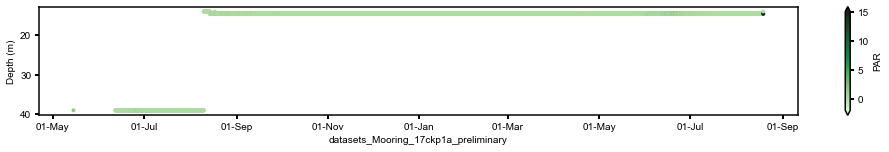

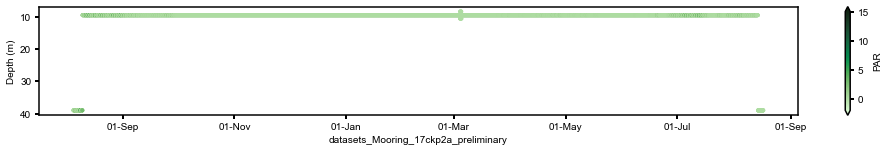

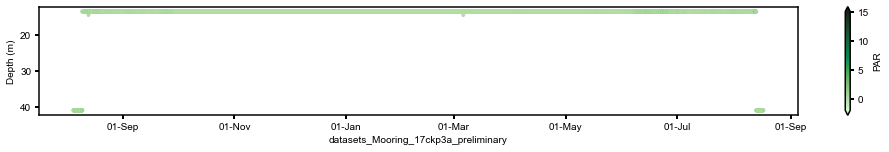

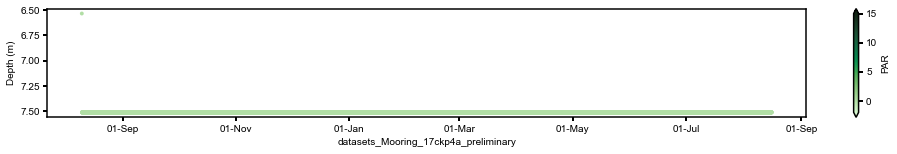

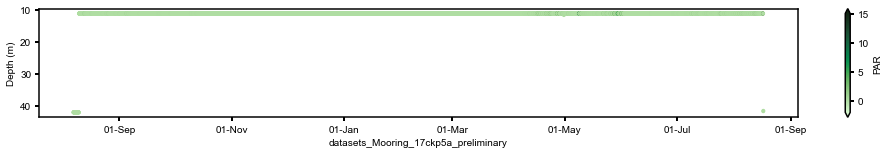

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1224x144 with 2 Axes>

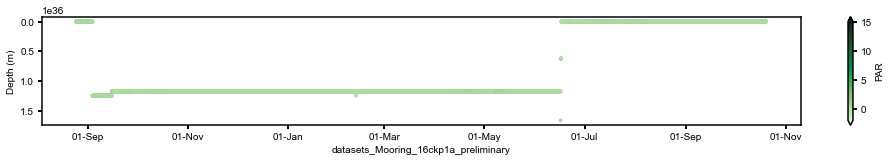

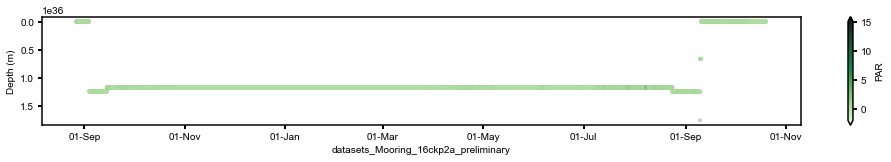

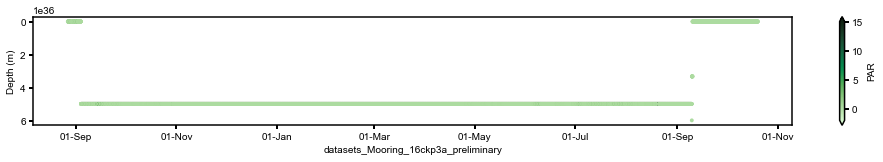

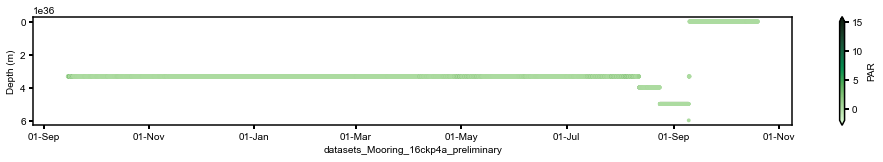

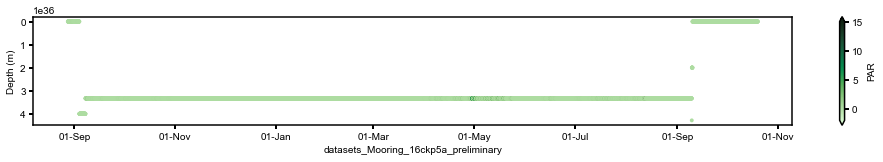

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

parameter = 'PAR'
for dfn, dft in dfs.items():
    df = dft.resample('1H').mean()
    try:
        if 'prel' in dfn:
            print(dfn)
            try:
                if 'final' in dfn:
                    fig, ax = plt.subplots(figsize=(17, 2))
                    cs = ax.scatter(df.index.values, df['depth'], s=15, c=df[parameter], marker='o', edgecolor='none', vmin=-2, vmax=15, cmap=cmocean.cm.algae)

                    ax.invert_yaxis()
                    #ax.set_xlim(df.index.min(), df.index.max())
                    xfmt = mdates.DateFormatter('%d-%b')
                    ax.xaxis.set_major_formatter(xfmt)

                    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
                    cbar.ax.set_ylabel(parameter)
                    ax.set_ylabel('Depth (m)')
                    ax.set_xlabel(dfn)

                    #fig.savefig(dfn+'.png',dpi=300)
                elif 'preliminary' in dfn:
                    fig, ax = plt.subplots(figsize=(17, 2))
                    cs = ax.scatter(df.index.values, df['depth'], s=15, c=df[parameter], marker='o', edgecolor='none', vmin=-2, vmax=15, cmap=cmocean.cm.algae)

                    ax.invert_yaxis()
                    #ax.set_xlim(df.index.min(), df.index.max())
                    xfmt = mdates.DateFormatter('%d-%b')
                    ax.xaxis.set_major_formatter(xfmt)

                    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
                    cbar.ax.set_ylabel(parameter)
                    ax.set_ylabel('Depth (m)')
                    ax.set_xlabel(dfn)
            except:
                ax.set_xlabel(dfn)
                continue
    except:
        print(f"{dfn} failed")

Text(0, 0.5, 'PAR')

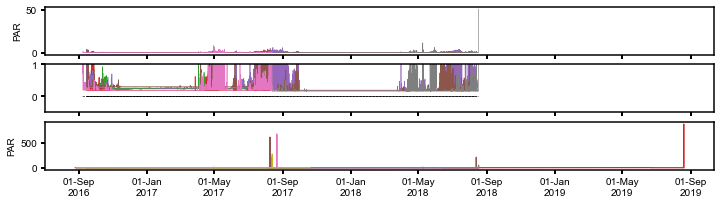

In [157]:
### final only
parameter = 'PAR'
fig, (ax3, ax2, ax1) = plt.subplots(3,1,sharex='col',figsize=(12,3))
for dfn, df in dfs.items():
    dft = df.resample('1H').mean()
    if 'final' in dfn:
        ax3.plot(dft.index.values, dft[parameter],linewidth=0.625, label=dfn)

        ax2.plot(dft.index.values, dft[parameter],linewidth=0.625, label=dfn)
        ax2.plot(dft.index.values, dft[parameter]*0,'k--',linewidth=0.625, label=dfn)
        ax2.set_ylim([-0.5,1])
        
ax3.xaxis.set_major_formatter(xfmt)
ax3.set_ylabel(parameter)


for dfn, df in dfs.items():
    dft = df.resample('1H').mean()
    if 'preliminary' in dfn:
        ax1.plot(dft.index.values, dft[parameter],linewidth=1.25, label=dfn)

xfmt = mdates.DateFormatter('%d-%b\n%Y')
ax1.xaxis.set_major_formatter(xfmt)

ax1.set_ylabel(parameter)



(736085.0, 737272.0)

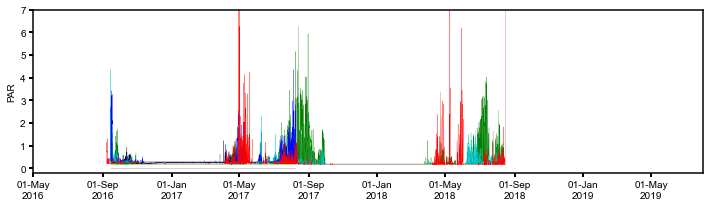

In [170]:
### final only

parameter = 'PAR'
fig, (ax1) = plt.subplots(1,1,sharex='col',figsize=(12,3))
for dfn, df in dfs.items():
    if 'ckp1a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        ax1.plot(dft.index.values, dft[parameter],'k',linewidth=0.25, label=dfn)

        ax1.plot(dft.index.values, dft[parameter]*0,'k--',linewidth=0.25, label='')
    if 'ckp2a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        ax1.plot(dft.index.values, dft[parameter],'g',linewidth=0.25, label=dfn)
    if 'ckp3a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        ax1.plot(dft.index.values, dft[parameter],'c',linewidth=0.25, label=dfn)
    if 'ckp4a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        ax1.plot(dft.index.values, dft[parameter],'b',linewidth=0.25, label=dfn)
    if 'ckp5a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        ax1.plot(dft.index.values, dft[parameter],'r',linewidth=0.25, label=dfn)



xfmt = mdates.DateFormatter('%d-%b\n%Y')
ax1.xaxis.set_major_formatter(xfmt)
ax1.set_ylim([-.2,7])
ax1.set_ylabel(parameter)
ax1.set_xlim(datetime.date(2016,5,1),datetime.date(2019,8,1))
#ax1.legend()

#fig.savefig('Arctic'+parameter+'_20162017.prelim.png',dpi=300)

In [169]:
parameter = 'PAR' #Chlorophyll_Fluorescence

# this works because there is only one flourometer on each deployment... resampling multiple fluorometers would average them and that isn't desired
for dfn, df in sorted(dfs.items()):
    if 'ckp1a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        dft[parameter].to_csv('Arctic'+parameter+'_20162017_CK1.csv', mode='a')
    if 'ckp2a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        dft[parameter].to_csv('Arctic'+parameter+'_20162017_CK2.csv', mode='a')
    if 'ckp3a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        dft[parameter].to_csv('Arctic'+parameter+'_20162017_CK3.csv', mode='a')
    if 'ckp4a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        dft[parameter].to_csv('Arctic'+parameter+'_20162017_CK4.csv', mode='a')
    if 'ckp5a' in dfn and ('final' in dfn):
        dft = df.resample('1H').mean()
        dft[parameter].to_csv('Arctic'+parameter+'_20162017_CK5.csv', mode='a')



In [167]:
dfn

'datasets_Mooring_16ckp9a_final'